In [59]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

from astropy.table import Table, vstack

import numpy as np 
import emcee

import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)
    
from asap.um_model_plot import plot_mtot_minn_smf, plot_dsigma_profiles
from asap.asap_data_io import parse_config, load_observed_data, \
    config_observed_data, config_um_data, load_um_data
from asap.asap_model_setup import setup_model
from asap.asap_likelihood import asap_flat_prior, asap_ln_like, asap_flat_prior_transform

from asap.asap_utils import *
from asap.asap_run_model import * 
from asap.asap_model_prediction import *
from asap.asap_likelihood import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


* Test and learn how to represent our model using PyMC3

In [6]:
import pymc3 as pm

import mpl_scatter_density

### Read in the data

In [3]:
config_file = '../asap/asap_default_config.yaml'

cfg_ini = parse_config(config_file)

global cfg, obs_data, um_data

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin3_default
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_new.npy
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_new.npy
# Covariances for SMFs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_m10_cov.npy
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# There are 15 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.5000 -- 12.2000 in 7 bins
# SMF for inner stellar mass: 
  10.7000 -- 11.8000 in 11 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    11 bins at 10.70 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the HSC data is    102060083.62 Mpc^3
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


In [45]:
um_data['um_mock']

mhalo_mask = um_data['um_mock']['logmh_host'] >= 13.0

logmh = np.array(um_data['um_mock']['logmh_host'])
logmh_vir = np.array(um_data['um_mock']['logmh_vir'])

logms_tot = np.array(um_data['um_mock']['logms_halo'])

frac_cen_tot = np.array(um_data['um_mock']['mtot_galaxy'] / 
                        um_data['um_mock']['mstar_mhalo'])

frac_ins_cen = np.array(um_data['um_mock']['sm'] / 
                        um_data['um_mock']['mtot_galaxy'])

frac_exs_cen = np.array(um_data['um_mock']['icl'] / 
                        um_data['um_mock']['mtot_galaxy'])

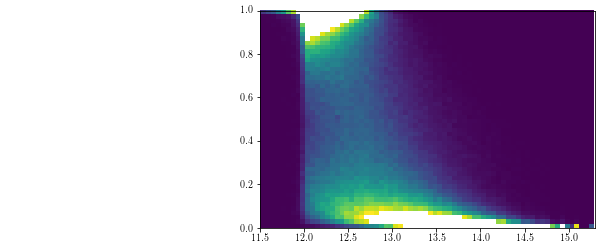

In [31]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

_ = ax.hist2d(logmh, frac_cen_tot, bins=(120, 50), cmax=1000, cmap='viridis')

_ = ax.set_xlim(11.5, 15.3)

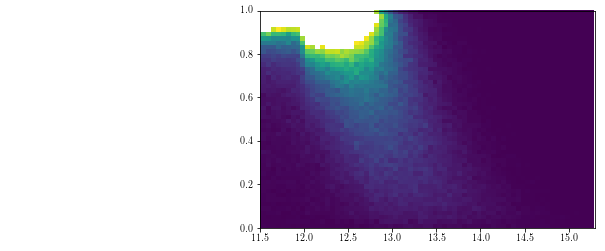

In [43]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

_ = ax.hist2d(logmh_vir, frac_ins_cen, bins=(120, 50), cmax=500, cmap='viridis')

_ = ax.set_xlim(11.5, 15.3)

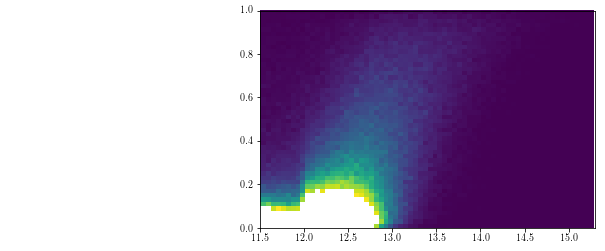

In [44]:
fig = plt.figure()

ax = fig.add_subplot(1,1,1)

_ = ax.hist2d(logmh_vir, frac_exs_cen, bins=(120, 50), cmax=500, cmap='viridis')

_ = ax.set_xlim(11.5, 15.3)

### Learn how to setup a PyMC model

In [48]:
logmh_logms = dict(x=logmh[mhalo_mask], y=logms_tot[mhalo_mask])

with pm.Model() as model:
    pm.glm.GLM.from_formula('y ~ x', logmh_logms)
    trace = pm.sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python2.7/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
 37%|███▋      | 933/2500 [30:18<50:54,  1.95s/it]/usr/local/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 433 samples.
  % (self._chain_id, n))
/usr/local/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)
/usr/local/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.893449346011061, but should be close to 0.8. Try to i

In [53]:
test_model = pm.Model()

with test_model:
    logm1 = pm.Normal('logm1', mu=11.2, sd=0.1)
    logm2 = pm.Normal('logm2', mu=11.5, sd=0.1)
    m10 = (10.0 ** logm1) * 0.8 + (10.0 ** logm2)
    

### Distribution test

In [55]:
config_file = 'test/asap_smdpl_mmax_m10_frac4_test_1.yaml'

cfg_ini = parse_config(config_file)

cfg, obs_data, um_data = initial_model(cfg_ini, verbose=True)

print(cfg['model_type'])

# Stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Weak lensing profile sample: s16a_wide2_massive_boxbin7_default
# Pre-computed SMF for inner logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.6.npy
# Pre-computed SMF for total logMs: /Users/song/Dropbox/work/project/hsc_um2/data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: None
# Using logm_10 as inner stellar mass.
# Using logm_max as total stellar mass.
# There are 12 weak lensing profiles in this sample
# SMF for total stellar mass: 
  11.6000 -- 12.3000 in 7 bins
# SMF for inner stellar mass: 
  10.8000 -- 11.8000 in 10 bins
# Pre-computed full SMF: primus_smf_z0.3_0.4.fits
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.60 < logMtot < 12.30
# The volume of the HSC data is    102060083.62 Mpc^3
# The volume of the UniverseMachine mock is    205348196.23 

In [62]:
(frac4d_burnin_samples, 
 frac4d_burnin_chains, 
 frac4d_burnin_lnprob, 
 frac4d_burnin_best, _, _) = mcmc_load_results(
    'test/asap_smdpl_mmax_m10_frac4_test_3_burnin.npz')

(frac4d_result_samples, 
 frac4d_result_chains, 
 frac4d_result_lnprob, 
 frac4d_result_best, _, _) = mcmc_load_results(
    'test/asap_smdpl_mmax_m10_frac4_test_3_run.npz')

print(frac4d_burnin_best)
print(frac4d_result_best)

[ 0.60845168  3.60101088 -0.02363876  0.02768991  0.63818674 -0.16791255
  0.0769024 ]
[ 5.73814226e-01  3.82388521e+00 -4.55844109e-02  8.41131828e-02
  8.65230319e-01  1.12904063e-01  2.32118290e-03]


# lnLikelihood: 200.274874, -368.729350, -168.454476
# N_data - N_param: 142


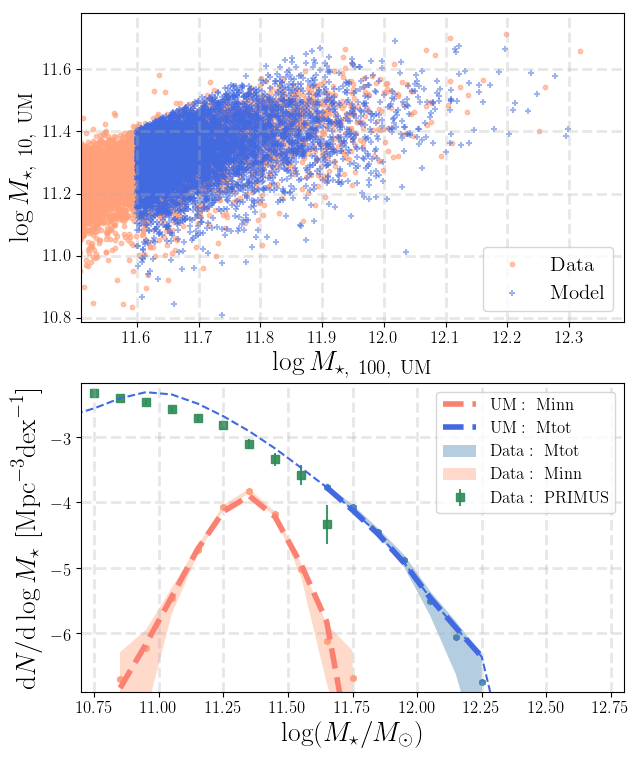

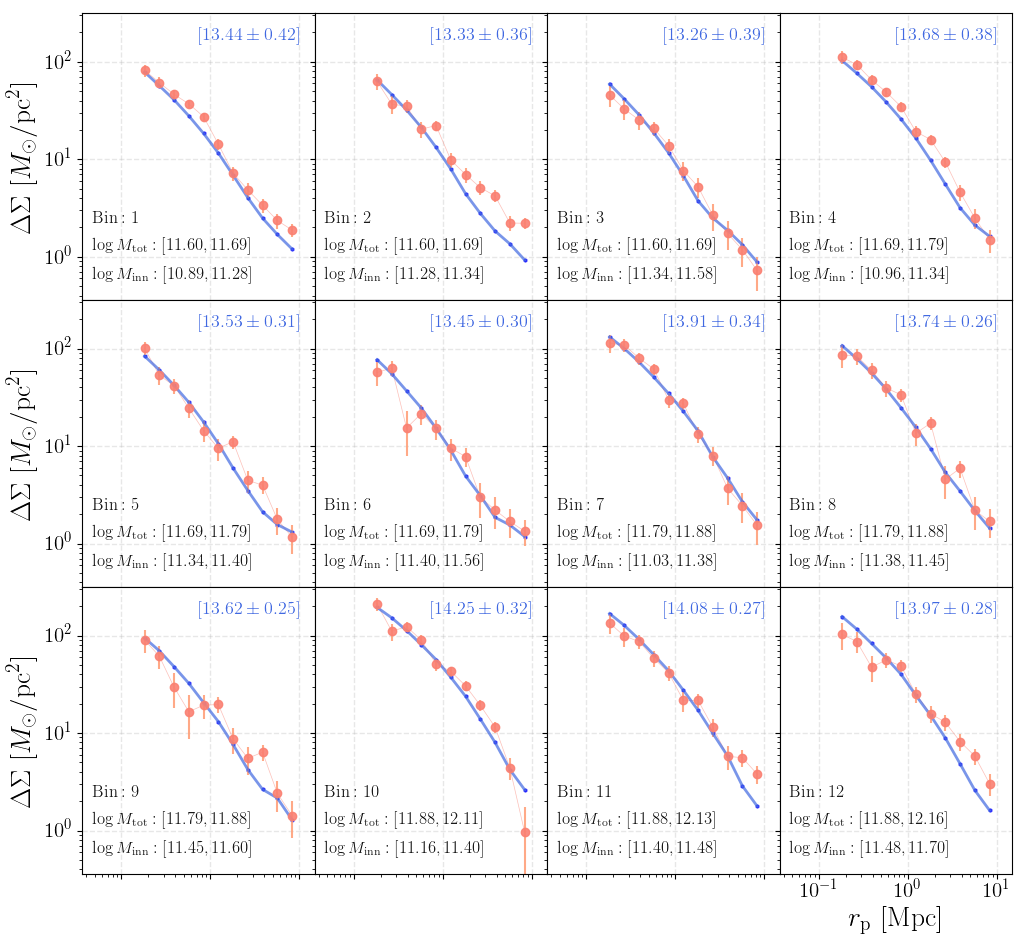

In [64]:
param_frac4 = frac4d_burnin_best


smf_lnlike, dsigma_lnlike = asap_ln_like(param_frac4, cfg, obs_data, um_data, 
                                         chi2=False, sep_return=True)
#smf_chi2, dsigma_chi2 = asap_ln_like(param_frac4, cfg, obs_data, um_data, 
#                                     chi2=True, sep_return=True)

print("# lnLikelihood: %f, %f, %f" % (smf_lnlike, dsigma_lnlike, 
                                      (smf_lnlike + dsigma_lnlike)))
#print("# Chi2: %f, %f, %f" % (smf_chi2, dsigma_chi2, (smf_chi2 + dsigma_chi2)))
print("# N_data - N_param: %d" % cfg['model_dof'])

um_mod_predicted = asap_predict_model(
    param_frac4, cfg, obs_data, um_data, 
    show_smf=True, show_dsigma=True, return_all=True)

(um_smf_tot, um_smf_inn, um_dsigma, 
 logms_inn_mod_all, logms_tot_mod_all, 
 logms_halo_mod_all, mask_tot) = um_mod_predicted

In [252]:
def get_masses(param=param_frac4, index=None):
    (_, _, _, logm1, logm2, _, _) = asap_predict_model(
        param_frac4, cfg, obs_data, um_data, return_all=True)
    
    if index is None:
        index = np.argmax(logm1)
    
    return logm1[index], logm2[index]

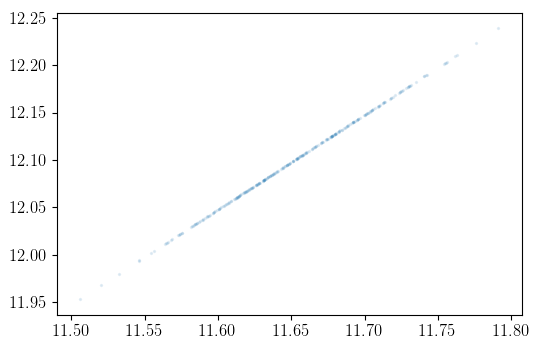

In [253]:
logm1, logm2 = zip(*[get_masses(index=630879) for i in range(300)])
logm1 = np.array(logm1)
logm2 = np.array(logm2)

plt.scatter(logm1, logm2, s=2, alpha=0.1)

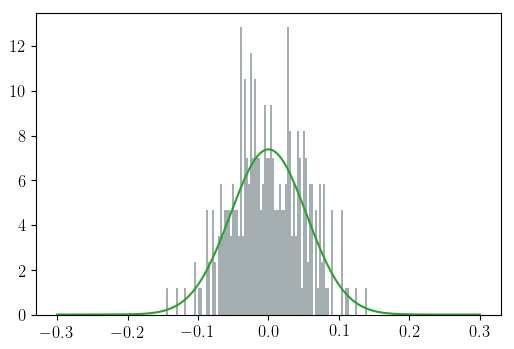

In [256]:
_ = plt.hist(logm1 - np.mean(logm1), bins=100, alpha=0.5, normed=True)
_ = plt.hist(logm2 - np.mean(logm2), bins=100, alpha=0.2, normed=True)

import matplotlib.mlab as mlab

x = np.linspace(-0.3, 0.3, 200)
plt.plot(x, mlab.normpdf(x, 0.0, 0.054))

In [251]:
um_data['um_mock']['logmh_vir'][630879]

14.384711742938283

In [255]:
-0.02363876 * (um_data['um_mock'][630879]['logmh_host'] - 15.5) + 0.02768991

0.05405394143950024